In [260]:
import pandas as pd
marketing = pd.read_csv("/Users/satya/Downloads/bank+marketing/bank/bank-full.csv", sep = ";")
marketing = pd.DataFrame(marketing)

# interpretation 
# lift chart
# feature importance
print(marketing.shape)
marketing.columns


(45211, 17)


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [261]:
# no missing values
print(marketing.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [262]:
marketing['age'] = marketing['age'].astype('int64')
marketing['balance'] = marketing['balance'].astype('int64')  # or float64 if needed
marketing['duration'] = marketing['duration'].astype('int64')
marketing['campaign'] = marketing['campaign'].astype('int64')
marketing['pdays'] = marketing['pdays'].astype('int64')
marketing['previous'] = marketing['previous'].astype('int64')

# Convert categorical columns to 'category' type
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
for col in categorical_columns:
    marketing[col] = marketing[col].astype('category')

# Check the data types
print(marketing.dtypes)


age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
y            category
dtype: object


In [263]:
# dropping duration of call since it's future info
marketing = marketing.drop(columns = ['duration'])
marketing['y'] = marketing['y'].map({'yes': 1, 'no': 0})

In [264]:
print(marketing.head())
marketing.dtypes

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  campaign  pdays  previous poutcome  y  
0  unknown    5   may         1     -1         0  unknown  0  
1  unknown    5   may         1     -1         0  unknown  0  
2  unknown    5   may         1     -1         0  unknown  0  
3  unknown    5   may         1     -1         0  unknown  0  
4  unknown    5   may         1     -1         0  unknown  0  


age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
campaign        int64
pdays           int64
previous        int64
poutcome     category
y            category
dtype: object

In [265]:
# split into train and validation (70/20/10)
from sklearn.model_selection import train_test_split

train, validation = train_test_split(marketing, test_size=0.2, random_state=42)

train, test = train_test_split(train, test_size=0.125, random_state=42)  

# Check the size of each split
print(f"Training Data: {train.shape}, {len(train) / len(marketing)}")
print(f"Validation Data: {validation.shape}, {len(validation) / len(marketing)}")
print(f"Test Data: {test.shape}, {len(test) / len(marketing)}")


Training Data: (31647, 16), 0.6999845170423127
Validation Data: (9043, 16), 0.20001769480878548
Test Data: (4521, 16), 0.09999778814890181


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X = train.drop(columns=['y'])
y = train['y']
# One-hot encode categorical features
X_dummies = pd.get_dummies(X, drop_first=False)


In [ ]:
rf_train = RandomForestClassifier(n_estimators=100, 
                                  random_state=12345, 
                                  oob_score=True)

rf_train.fit(X_dummies, y)

print(f"Out-of-Bag Score: {rf_train.oob_score_}")


from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
print("defining the parameter grid")
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_features': [3, 5, 7, 10, 12, 'sqrt'],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}

rf = RandomForestClassifier(random_state = 12345)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 0)

grid_search.fit(X_dummies, y)

print("Best parameters found: ", grid_search.best_params_)

In [226]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

rf_train = RandomForestClassifier(n_estimators = 600,
                                max_features = 5,
                                  random_state = 12345,
                                  bootstrap = True,
                                  oob_score = True)

rf_train.fit(X_dummies, y)

RandomForestClassifier(max_features=5, n_estimators=600, oob_score=True,
                       random_state=12345)

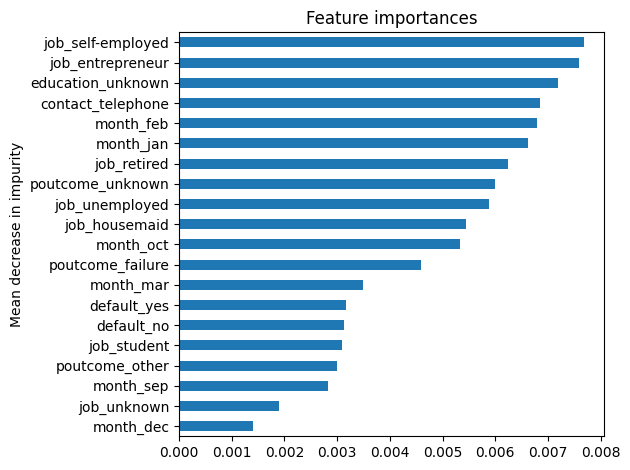

In [210]:
from matplotlib import pyplot as plt
forest_importances = pd.Series(rf_train.feature_importances_, index = rf_train.feature_names_in_)
forest_importances = forest_importances.sort_values(ascending=True).head(20)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)  # Plot horizontal bars
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


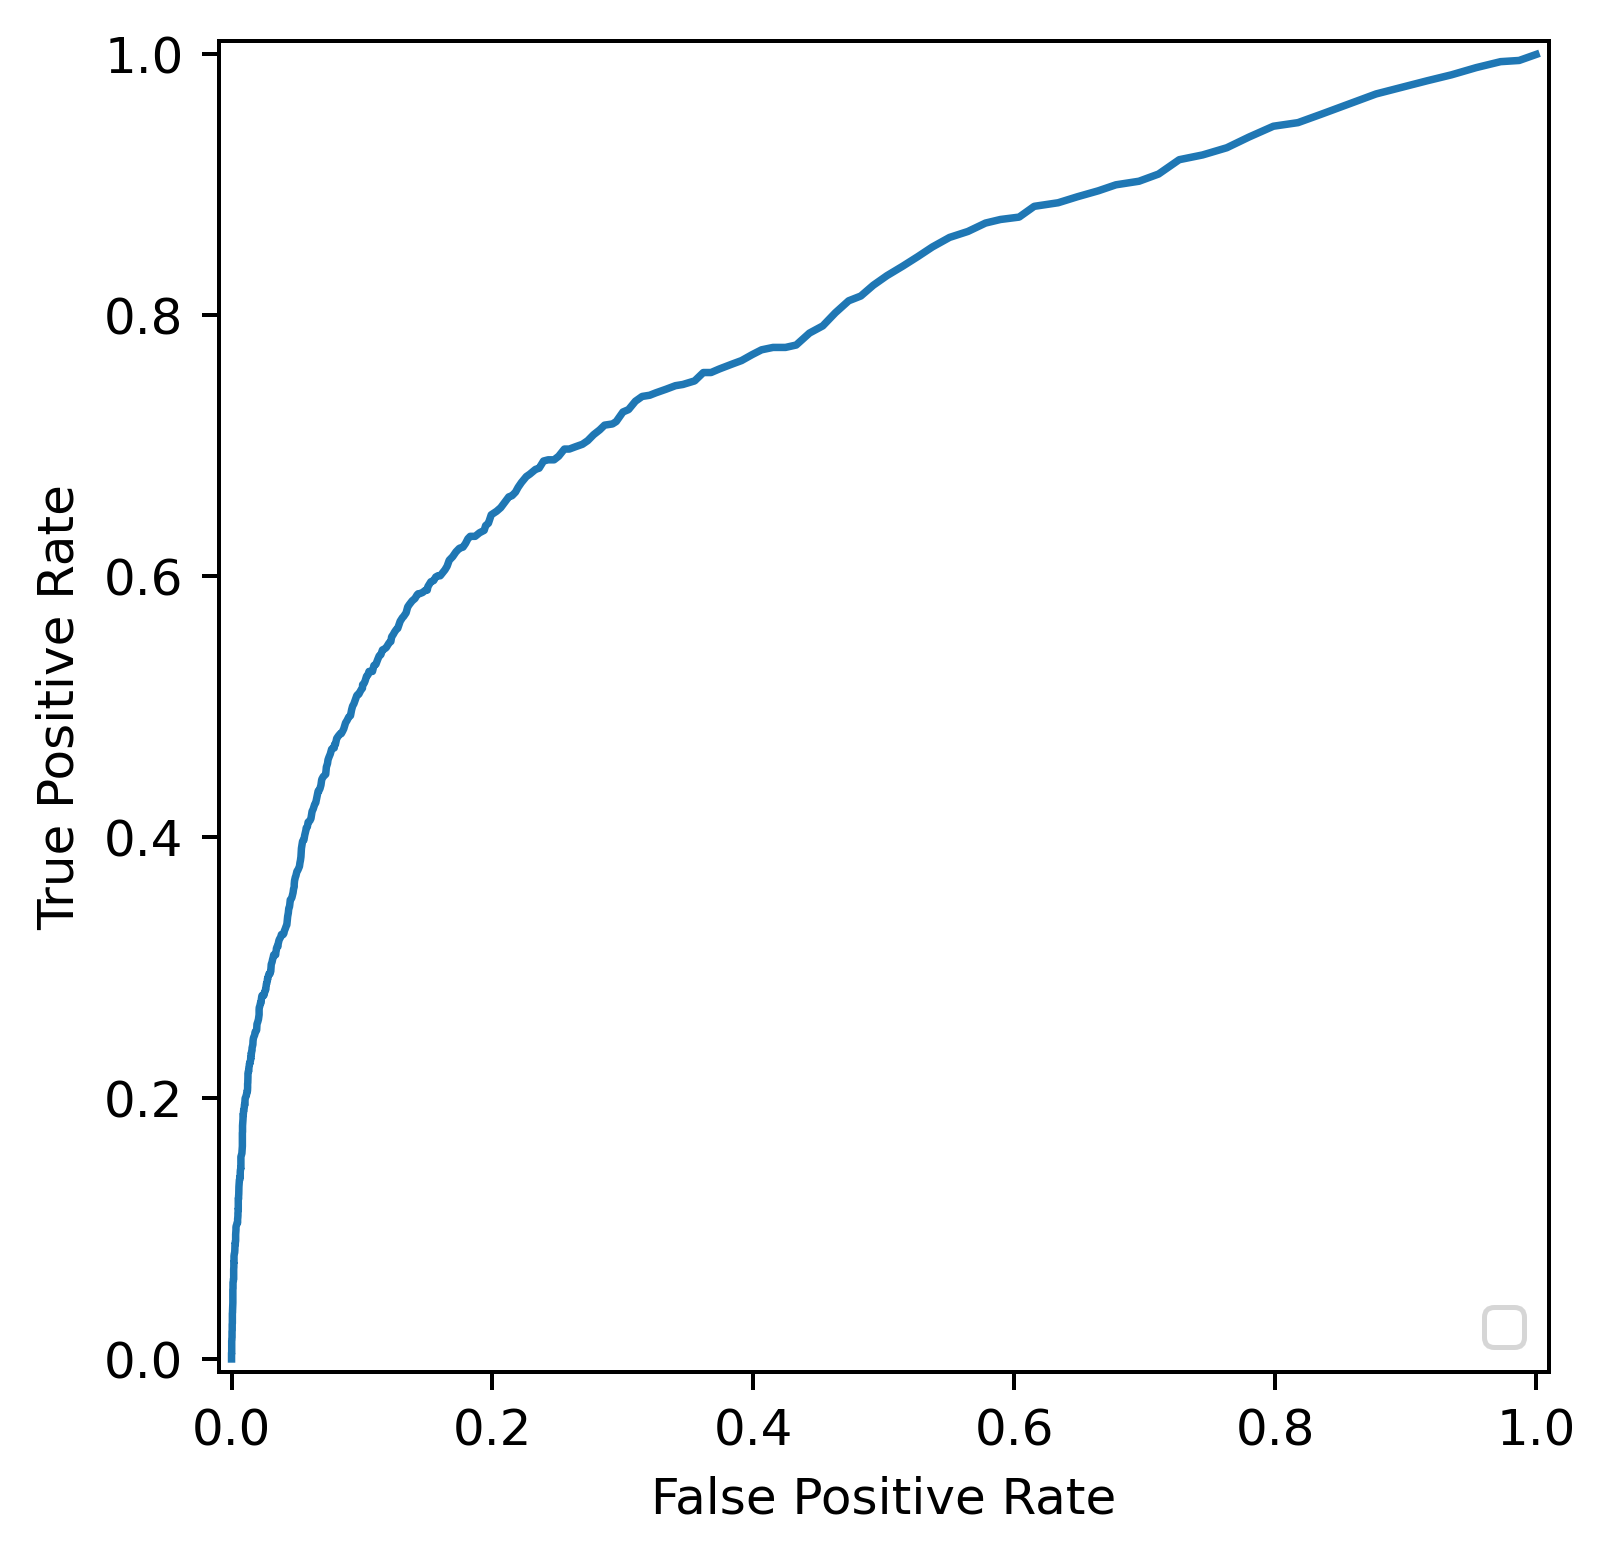

AUC: 0.7798492374964728


In [279]:
y_pred_proba = rf_train.predict_proba(X_val_dummies)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

print(f"AUC: {auc(fpr, tpr)}")

Optimal Threshold: 0.12


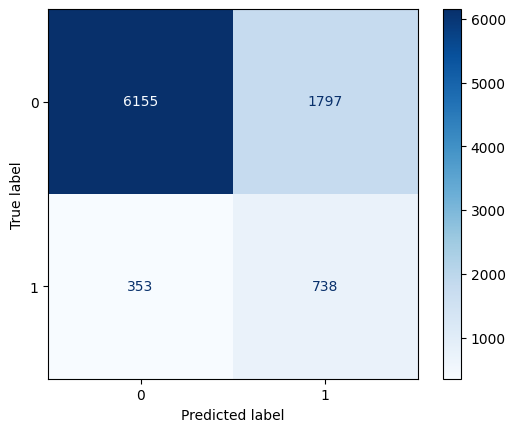

In [235]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Compute ROC and Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
optimal_threshold = thresholds[(tpr - fpr).argmax()]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Classification using Optimal Threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_train.classes_)
disp.plot(cmap='Blues')
plt.show()

In [236]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

fnr = fn / (fn + tp)
print(f"False Negative Rate (FNR): {fnr:.4f}")

Accuracy: 0.7622
False Negative Rate (FNR): 0.3236


In [169]:
# trying XGBoost next
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [15, 20, 25, 30, 35, 40, 45, 50], # number of trees
    'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.25, 0.5, 0.75, 1]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 2, verbose = 0, n_jobs= -1)

grid_search.fit(X_select, y)

grid_search.best_params_

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

{'eta': 0.25, 'max_depth': 2, 'n_estimators': 45, 'subsample': 0.75}

In [216]:
import numpy as np
X_train_r = X.copy()
X_train_r['random'] = np.random.normal(0, 1, len(X_train_r))
X_select = X.drop(columns = ['job', 'default'])
X_select = pd.get_dummies(X_select, drop_first=False)

scale_pos_weight = weights_dict[0] / weights_dict[1]


In [217]:
xgb_train = XGBClassifier(n_estimators = 45,
                        subsample = 0.75,
                        random_state = 12345, 
                        eta = 0.25, 
                        max_depth = 2,
                        scale_pos_weight=scale_pos_weight)

xgb_train.fit(X_select, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.25, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=45,
              n_jobs=None, num_parallel_tree=None, ...)

/var/folders/00/hsjhd04n2kjgfbfc370y7wzr0000gn/T/ipykernel_58327/1445967723.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


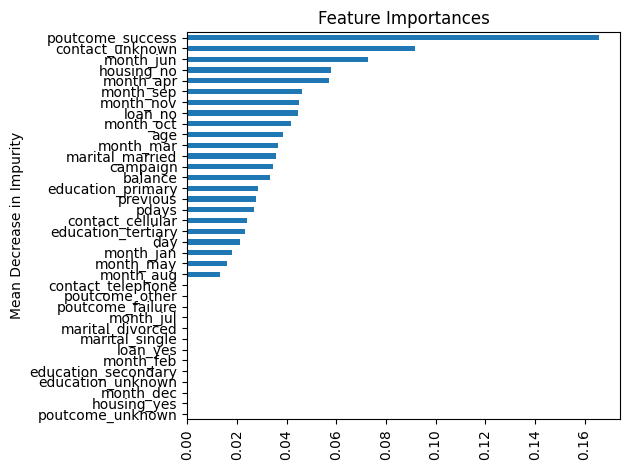

In [218]:
xgb_importances = pd.Series(xgb_train.feature_importances_, index=xgb_train.feature_names_in_)
xgb_importances = xgb_importances.sort_values(ascending=True).head(40)
fig, ax = plt.subplots()
xgb_importances.plot.barh(ax=ax) 
ax.set_title("Feature Importances")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


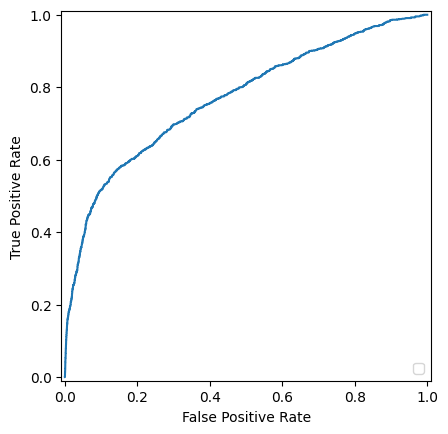

AUC: 0.7690937098300159
Accuracy: 0.7977
False Negative Rate (FNR): 0.3721


In [219]:
from sklearn.metrics import RocCurveDisplay, auc
import matplotlib.pyplot as plt
X_val = X_val.drop(columns=['job', 'default'])
X_val_dummies = pd.get_dummies(X_val, drop_first=False)
y_pred_proba = xgb_train.predict_proba(X_val_dummies)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

print(f"AUC: {auc(fpr, tpr)}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

fnr = fn / (fn + tp)
print(f"False Negative Rate (FNR): {fnr:.4f}")

In [181]:
print("Training feature names:", list(X_select.columns))
print("Input feature names:", list(X_val_dummies.columns))

Training feature names: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']
Input feature names: ['age', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome']


In [134]:
# try catboost
from catboost import CatBoostClassifier

# Define the model
cat = CatBoostClassifier()

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}
cat_features= ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=2, n_jobs=-1, verbose = 0)

# Fit grid search on training data
grid_search.fit(X, y, cat_features=cat_features)

0:	learn: 0.6631615	total: 64.5ms	remaining: 6.38s
0:	learn: 0.6630219	total: 65.4ms	remaining: 6.47s
1:	learn: 0.6362541	total: 73.7ms	remaining: 3.61s
1:	learn: 0.6360172	total: 74ms	remaining: 3.63s
0:	learn: 0.6347079	total: 66ms	remaining: 6.53s
0:	learn: 0.6344360	total: 71.3ms	remaining: 7.05s
2:	learn: 0.6112790	total: 84.1ms	remaining: 2.72s
2:	learn: 0.6112815	total: 85.4ms	remaining: 2.76s
1:	learn: 0.5869286	total: 79ms	remaining: 3.87s
0:	learn: 0.6631126	total: 69.5ms	remaining: 6.88s
3:	learn: 0.5887275	total: 91.2ms	remaining: 2.19s
1:	learn: 0.5872879	total: 94.7ms	remaining: 4.64s
4:	learn: 0.5681556	total: 101ms	remaining: 1.92s
3:	learn: 0.5897840	total: 102ms	remaining: 2.45s
1:	learn: 0.6363920	total: 82.6ms	remaining: 4.05s
2:	learn: 0.5481300	total: 96.7ms	remaining: 3.13s
0:	learn: 0.6632551	total: 73.2ms	remaining: 7.25s
5:	learn: 0.5499047	total: 108ms	remaining: 1.69s
2:	learn: 0.6114549	total: 88.9ms	remaining: 2.87s
4:	learn: 0.5701983	total: 110ms	remaini

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x31f5cc8d0>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.05, 0.1]})

In [135]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'depth': 7, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}


In [267]:
cat_train = CatBoostClassifier(iterations= 200,
                                depth = 7,
                                l2_leaf_reg = 5,
                                learning_rate = 0.05,
                                verbose = 0,
                                class_weights=[weights_dict[0], weights_dict[1]])

cat_train.fit(X, y, cat_features=cat_features)

In [222]:
print(cat_features)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


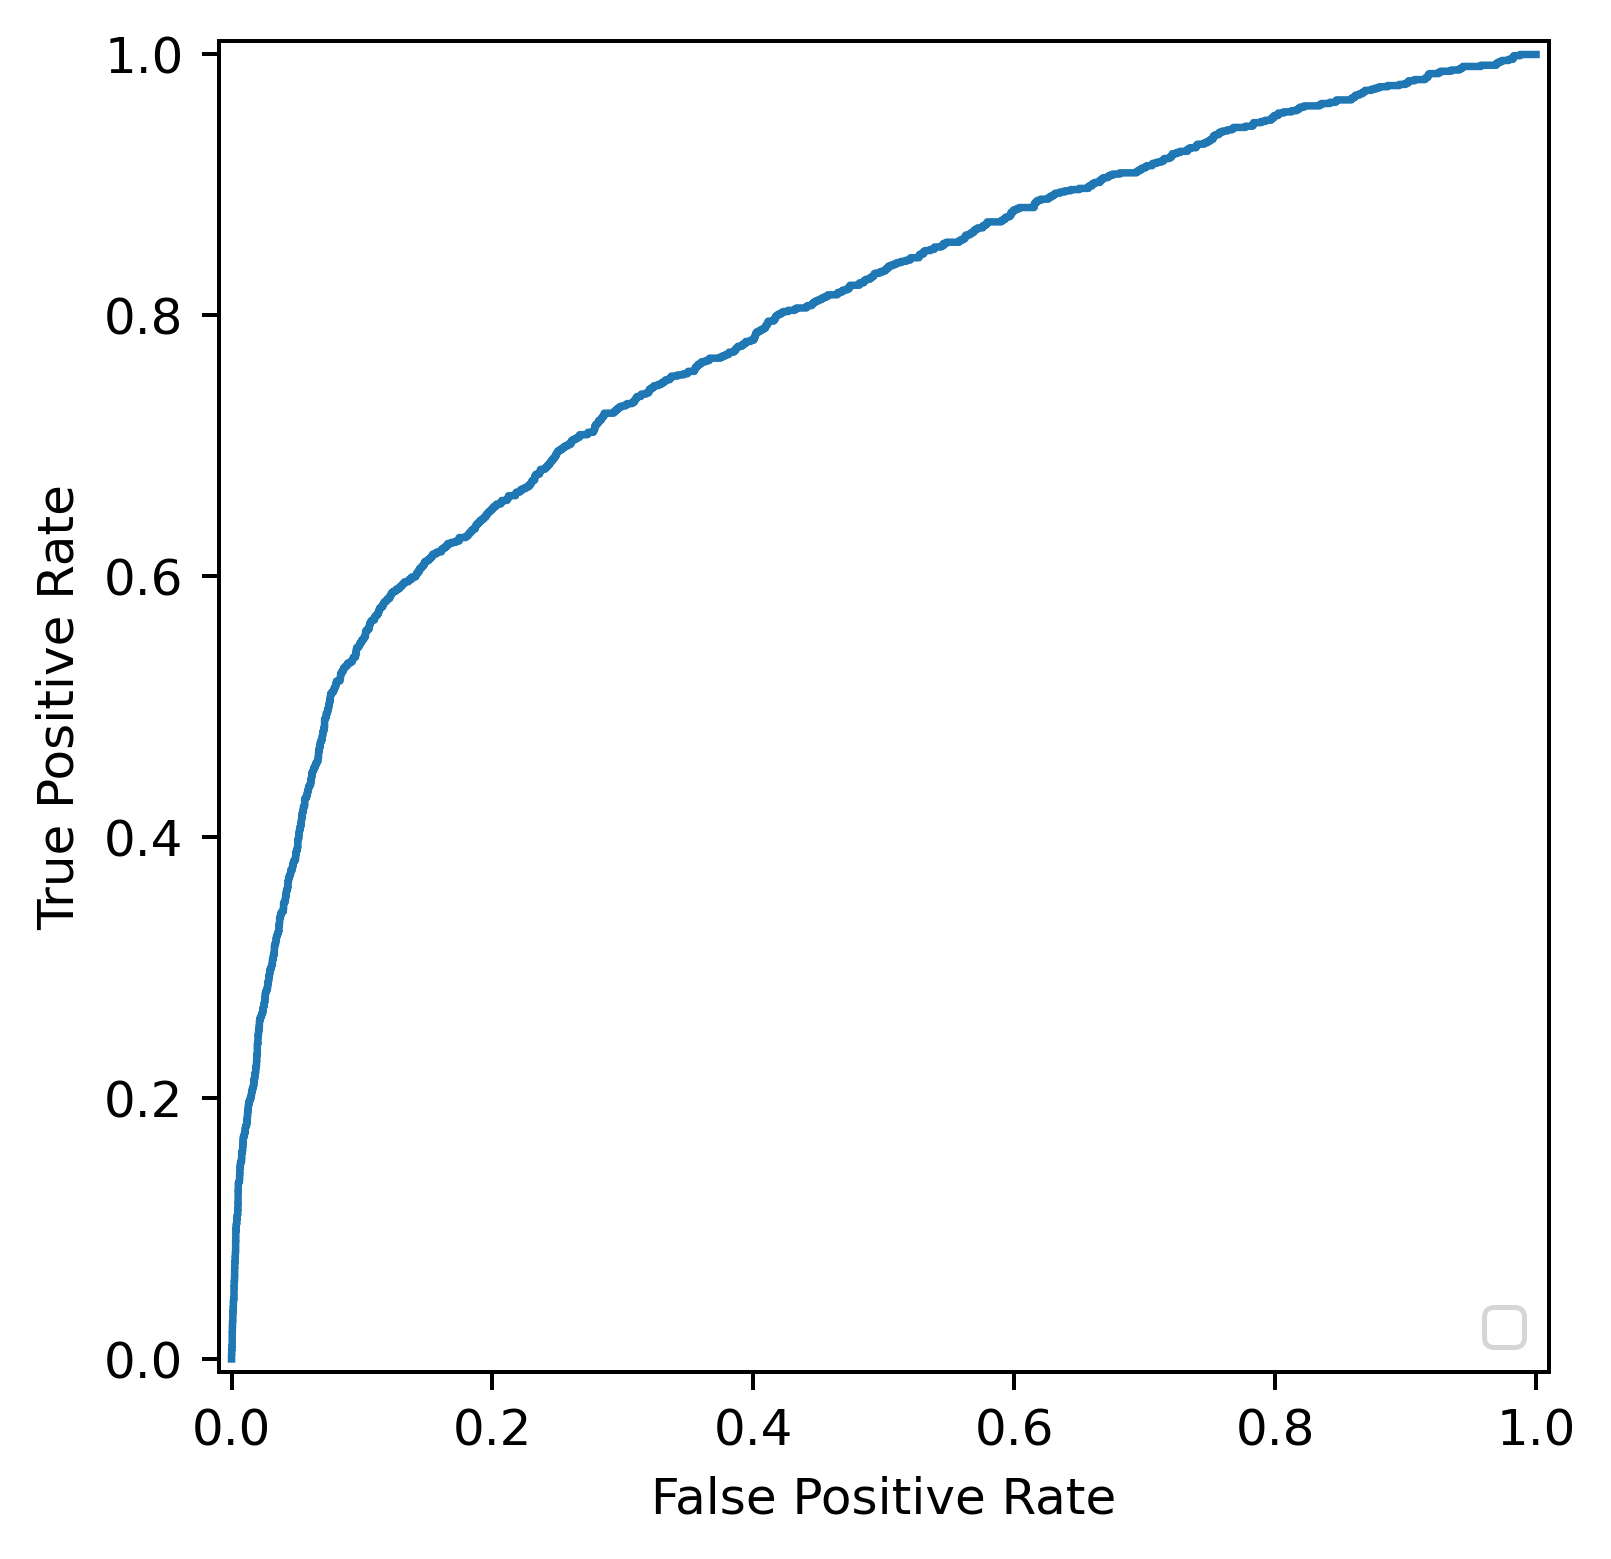

AUC: 0.7883674641801312
Accuracy: 0.7622
False Negative Rate (FNR): 0.3236


In [269]:
from sklearn.metrics import RocCurveDisplay, auc
import matplotlib.pyplot as plt
X_val = validation.drop(columns=['y'])

y_pred_proba = cat_train.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

print(f"AUC: {auc(fpr, tpr)}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

fnr = fn / (fn + tp)
print(f"False Negative Rate (FNR): {fnr:.4f}")

Optimal Threshold: 0.14


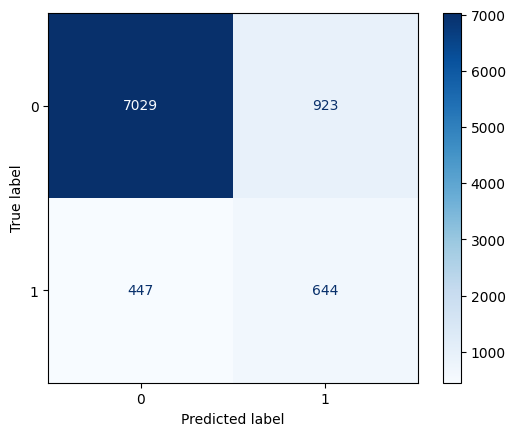

In [154]:
# Compute ROC and Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
optimal_threshold = thresholds[(tpr - fpr).argmax()]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Classification using Optimal Threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_train.classes_)
disp.plot(cmap='Blues')
plt.show()

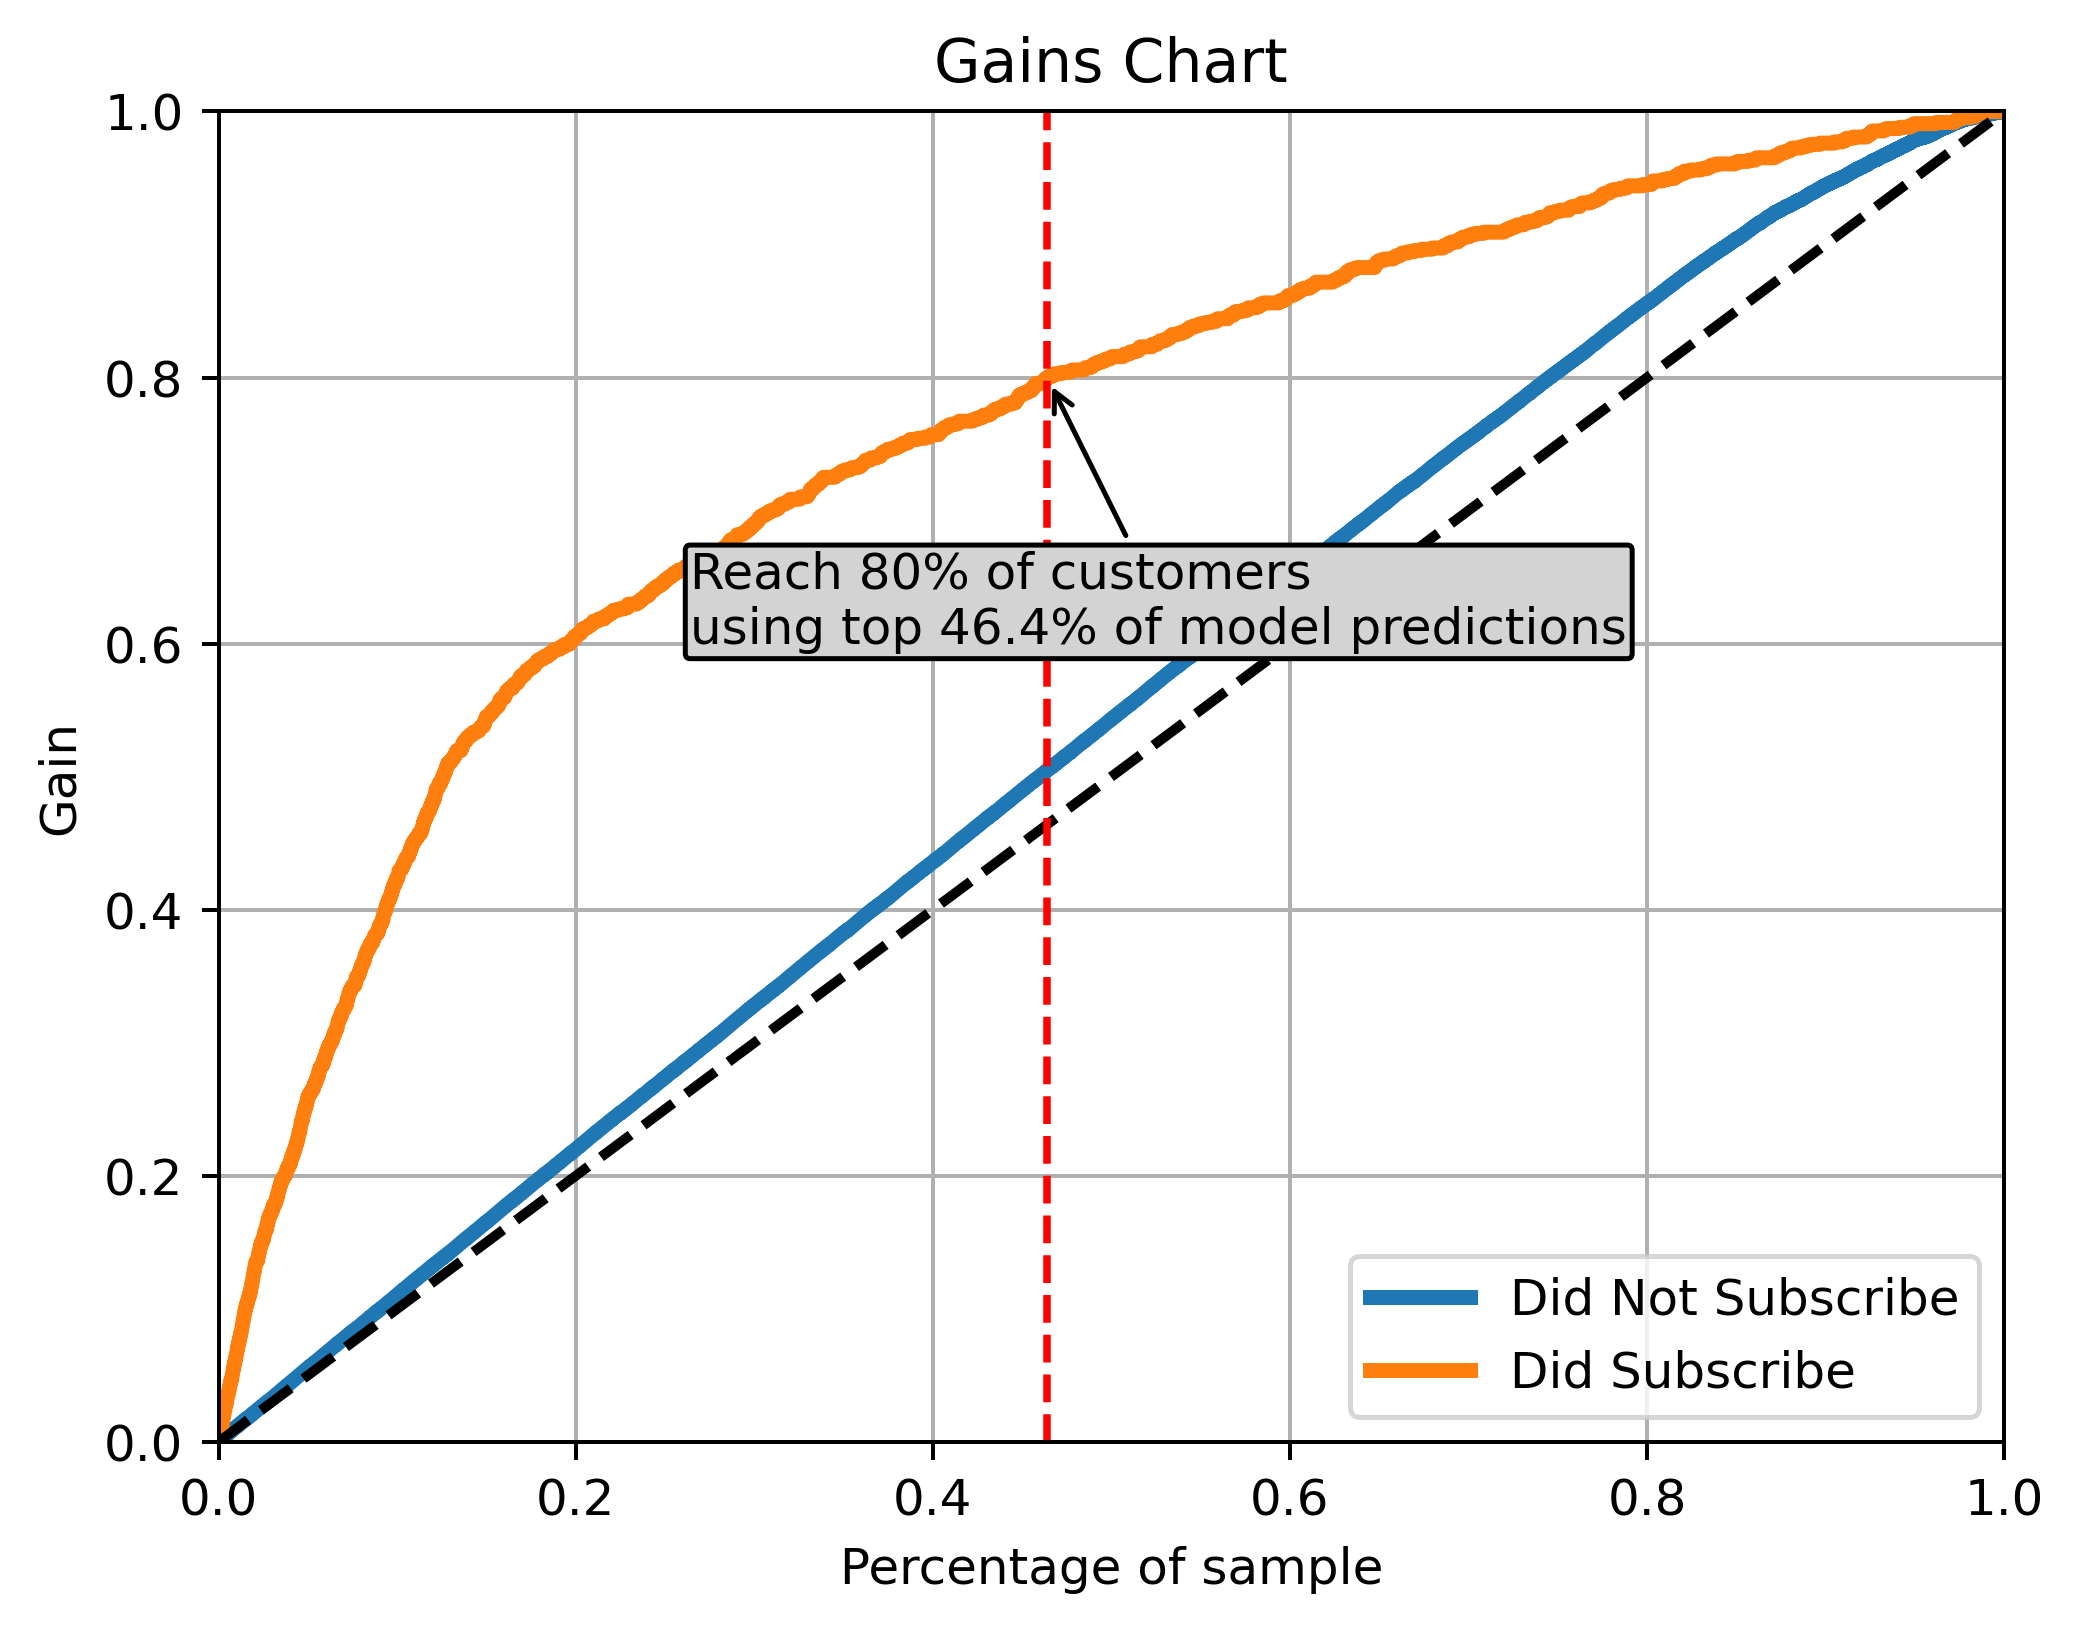

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# gain chart with label

X_val = validation.drop(columns=['y'])
y_val = validation['y']

y_pred_proba = cat_train.predict_proba(X_val)

percent_of_population, percent_of_positive = skplt.helpers.cumulative_gain_curve(y_val, y_pred_proba[:, 1])
gain_threshold = 0.8
x_for_80_gain = percent_of_population[np.argmin(np.abs(percent_of_positive - gain_threshold))]

ax = skplt.metrics.plot_cumulative_gain(y_val, y_pred_proba, title="Gains Chart")

legend_labels = ["Did Not Subscribe", "Did Subscribe"]
ax.legend(legend_labels, loc="lower right", frameon=True)

plt.axvline(x=x_for_80_gain, color='red', linestyle='--', label="80% Gain")

# annotation bubble
plt.annotate(
    f"Reach 80% of customers\nusing top {x_for_80_gain:.1%} of model predictions",  
    xy=(x_for_80_gain, gain_threshold), 
    xytext=(x_for_80_gain - 0.2, gain_threshold - 0.2),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),  
    bbox=dict(boxstyle="round,pad=0.1", edgecolor='black', facecolor='lightgray'),  
    fontsize=10,  # Text size
)

plt.show()


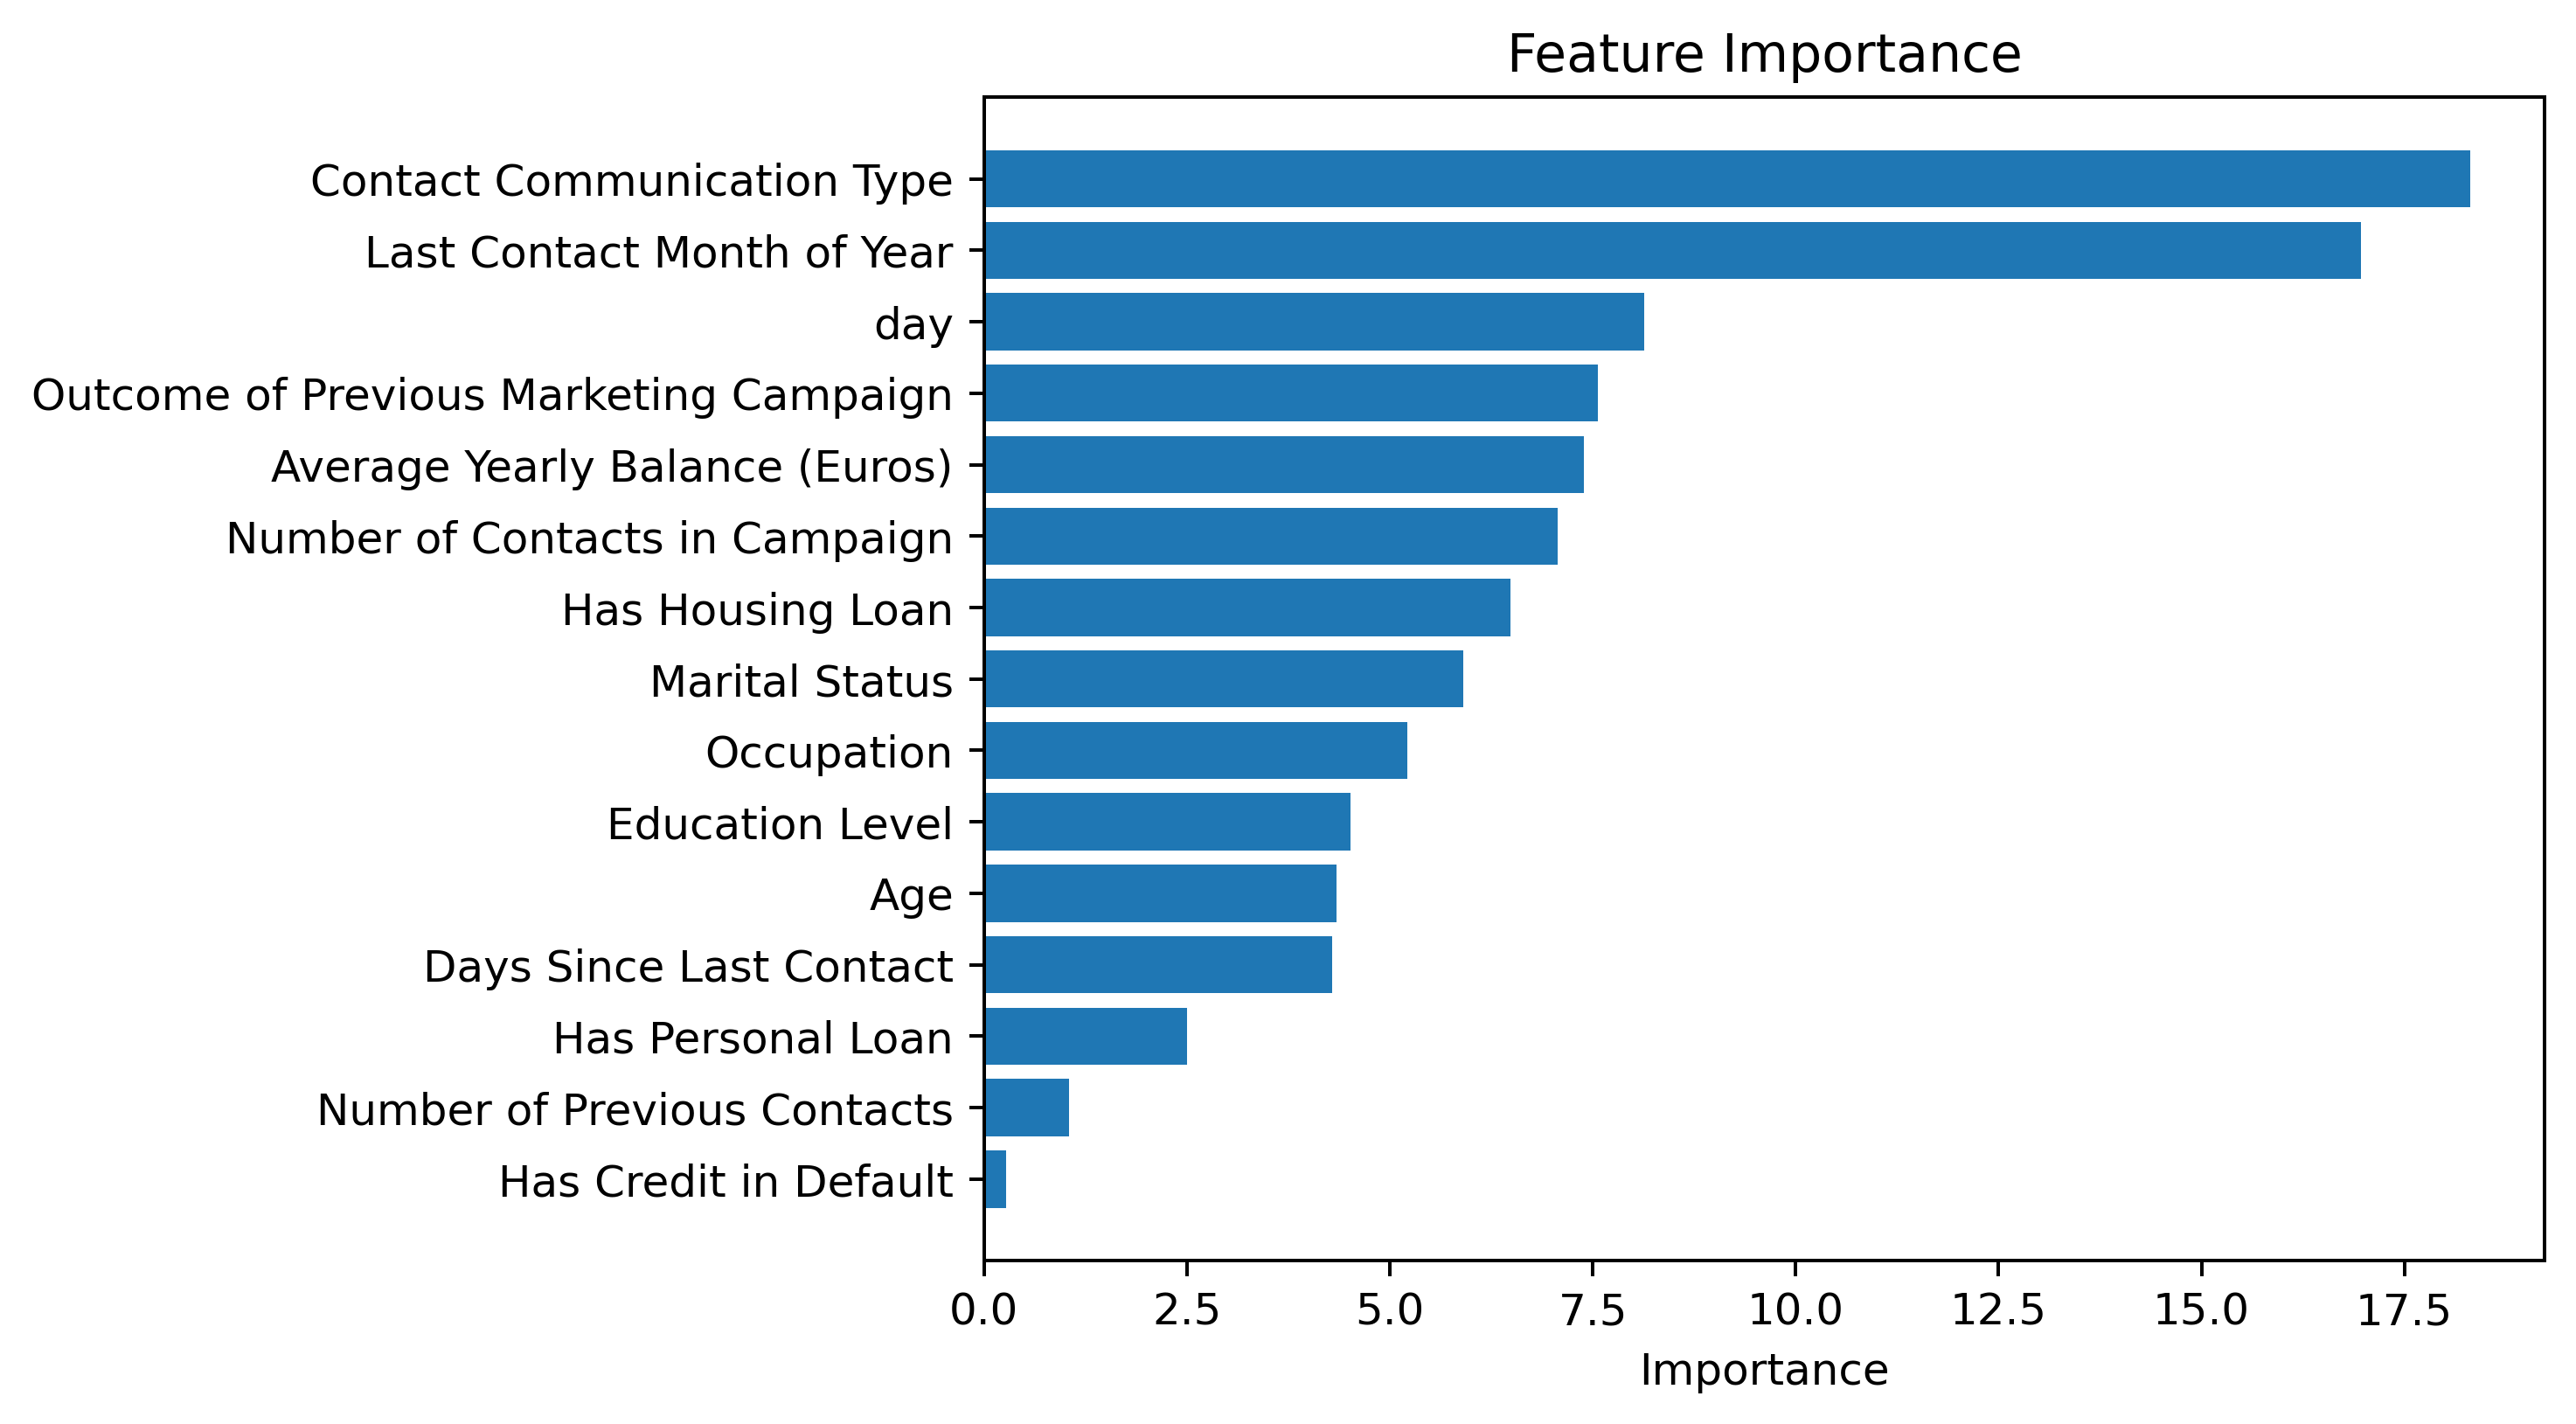

In [ ]:
# feature importances from CatBoost
importances = cat_train.get_feature_importance(type='FeatureImportance')
feature_names = cat_train.feature_names_

sorted_idx = np.argsort(importances)[::+1]  
sorted_importances = np.array(importances)[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# replacing variable names with descriptions
custom_feature_names = {
    'age': 'Age',
    'job': 'Occupation',
    'marital': 'Marital Status',
    'education': 'Education Level',
    'default': 'Has Credit in Default',
    'balance': 'Average Yearly Balance (Euros)',
    'housing': 'Has Housing Loan',
    'loan': 'Has Personal Loan',
    'contact': 'Contact Communication Type',
    'day_of_week': 'Last Contact Day of the Week',
    'month': 'Last Contact Month of Year',
    'duration': 'Last Contact Duration (seconds)',
    'campaign': 'Number of Contacts in Campaign',
    'pdays': 'Days Since Last Contact',
    'previous': 'Number of Previous Contacts',
    'poutcome': 'Outcome of Previous Marketing Campaign',
    'y': 'Subscription to Term Deposit'
}

mapped_feature_names = [custom_feature_names.get(name, name) for name in sorted_feature_names]

plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), mapped_feature_names)  # Use custom mapped names
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


In [ ]:
# light GBM
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model = lgb.LGBMClassifier()

param_grid = {
    'learning_rate': [0.10, 0.05, 0.2],
    'num_iterations': [10, 20, 30, 40, 50],  # Number of boosting rounds
    'max_bin': [20, 50, 100],      # Number of bins for continuous features
    'min_data_in_leaf': [5, 10, 15],   # Minimum samples per leaf
    'num_leaves': [5, 10, 15, 20]}      # Max number of leaves per tree

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose = 0)

grid_search.fit(X, y)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positi

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[Ligh

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024078 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028765 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045210 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [In

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] [b

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number o

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be igno

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029288 seconds.
You can set `force_row_wise=true` 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021930 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ign

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027478 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026303 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025339 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Curren

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017811 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014602 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_sa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023570 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number o

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be igno

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Wa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignore

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Cu

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029764 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024644 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]:

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019278 seconds.
You can set `force_row_wise=true` to r

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025570 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[Light

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.02992

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Curre

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignore

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_d

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be i

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021281 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number o

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021370 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [b

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020099 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Cur

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Cur

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020998 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [In

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignore

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_d

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Curre

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.02937

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017897 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019558 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used feat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019735 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015824 seconds.
You can set `force_row_wise=true` to remove 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ign

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Number of data points in the 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023015 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number o

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number o

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_sa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be igno

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020829 seconds.
You can set `force_row_wise=true` 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]:

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017323 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020455 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignore

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017630 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:Bo

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017313 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[Light

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.02992

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGB

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020893 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017194 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023632 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Cur

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [In

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current valu

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018807 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positi

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used feat

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [In

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Cur

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[Ligh

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Cur

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be igno

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignor

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:Bo

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017286 seconds.
You can set `force_row_wise=true` to remove 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017974 seconds.
You can set `force_row_wise=true` 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignore

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ign

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 158

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018691 seconds.
You can set `force_row_wise=

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018099 seconds.
You can set `force_row_wis

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ig

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[Light

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM]

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] Au

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_sa

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021625 seconds.
You can set `force_row_w

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923
[LightGBM] [Warning] min

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be 

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1837, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 15823, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116097 -> initscore=-2.029923
[LightGBM] [Info] Start training from score -2.029923


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 1838, number of negative: 13986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 15824, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116153 -> initscore=-2.029379
[LightGBM] [Info] Start training from score -2.029379


/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 3675, number of negative: 27972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029651
[LightGBM] [Info] Start training from score -2.029651


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.2],
                         'max_bin': [20, 50, 100],
                         'min_data_in_leaf': [5, 10, 15],
                         'num_iterations': [10, 20, 30, 40, 50],
                         'num_leaves': [5, 10, 15, 20]})

In [147]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'learning_rate': 0.2, 'max_bin': 100, 'min_data_in_leaf': 5, 'num_iterations': 50, 'num_leaves': 5}


In [224]:
lgb_model = lgb.LGBMClassifier(
    learning_rate= 0.2,                 # Set learning rate to 0.1
    num_iterations= 50,                 # Maximum number of boosting rounds (max_rounds)
    max_bin= 100,                        # Maximum number of bins for continuous features
    num_leaves= 5,                     # Maximum number of leaves in the trees
    min_data_in_leaf= 5,              # Minimum number of samples required to be a leaf
    scale_pos_weight= scale_pos_weight

)
lgb_model.fit(X, y)

/opt/anaconda3/envs/SummerPython3_11_9/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 3675, number of negative: 27972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029651
[LightGBM] [Info] Start training from score -2.029651


LGBMClassifier(learning_rate=0.2, max_bin=100, min_data_in_leaf=5,
               num_iterations=50, num_leaves=5,
               scale_pos_weight=0.02627627627627627)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


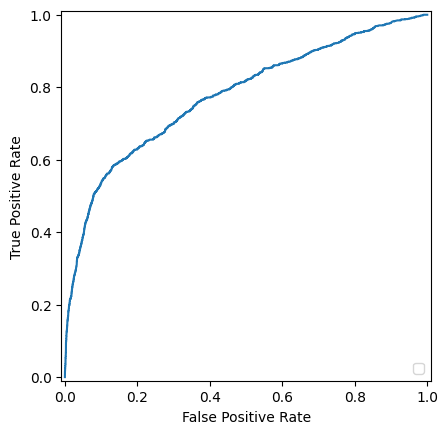

AUC: 0.7763955409819134
Accuracy: 0.7977
False Negative Rate (FNR): 0.3721


In [225]:
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

print(f"AUC: {auc(fpr, tpr)}")

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

fnr = fn / (fn + tp)
print(f"False Negative Rate (FNR): {fnr:.4f}")

     Feature  Importance
10     month          46
12     pdays          27
9        day          17
5    balance          16
11  campaign          16
0        age          15
8    contact          15
14  poutcome          12
1        job           9
2    marital           7


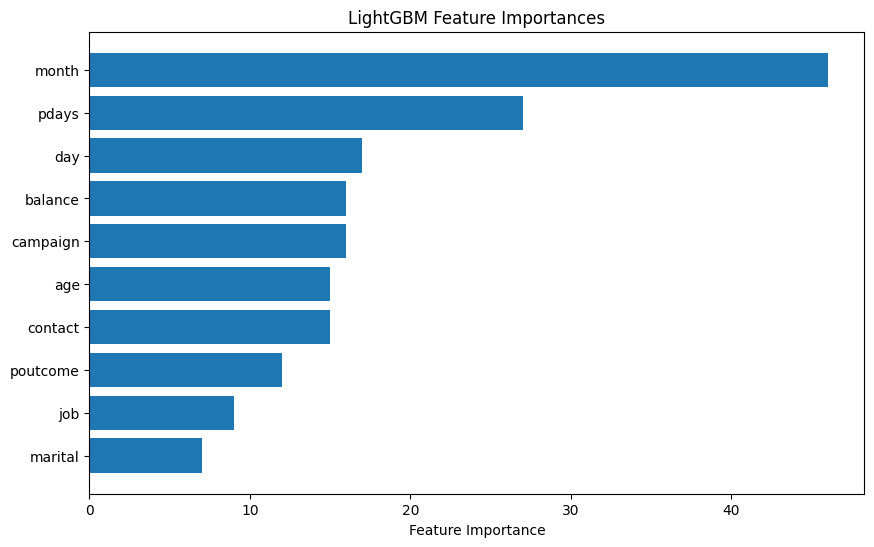

In [ ]:
# Get feature importances
importances = lgb_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(10)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importances")
plt.show()